In [1]:
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%matplotlib inline

## NN on Franke Function

In this exercise I will develop my own NN and use it against the same weather radar image. 

- Gjer meg opp ein meining for kostfunksjon. MSE fordi den har ein simpel derivert i C - kostfunksjonen
- gjør NN klart for ulike aktiveringsfunksjoner, neste

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from regression import OLS
from neural_network import NeuralNetwork
from regression import OLS


In [ ]:
from franke_function import FrankeFunction as Fr
import seaborn as sns
import tqdm
from sklearn.metrics import r2_score
from sklearn.neural_network import MLPRegressor

def output_func(x): # linear output to fit surface
    return x

learning_rate = np.linspace(0.000001, 0.005, 5) #different learning rates, include 
regularization = np.linspace(0, 0.2, 3)
k_folds = 5
batch_size = 32
n_epochs = 200
hidden_layer_sizes = [10, 10, 10]
# flere hidden layers treng fleire epochs

train_accuracy = np.zeros((len(learning_rate), len(regularization)))
test_accuracy = np.zeros((len(learning_rate), len(regularization)))
train_accuracy_skl = np.zeros((len(learning_rate), len(regularization)))
test_accuracy_skl = np.zeros((len(learning_rate), len(regularization)))

#Use radar data:
#z = radar_rescaled
#x = np.arange(z.shape[1])
#y = np.arange(z.shape[0])
#x, y = np.meshgrid(x, y)

x = np.linspace(0, 1, 50)
y = np.linspace(0, 1, 50)
x, y = np.meshgrid(x, y)
noise = np.random.randn(x.shape[0], y.shape[1])
z = Fr(x, y) + noise*0.05

#cross validation
xyz_shuffle = np.hstack([x.reshape(-1,1), y.reshape(-1,1), z.reshape(-1,1)])
np.random.shuffle(xyz_shuffle) # shuffle along axis 0
xyz_folds = np.array_split(xyz_shuffle, k_folds)

#my own implementation
for i in tqdm.tqdm(range(len(learning_rate))):
    for j in range(len(regularization)):
        R2_test = []
        R2_train = []
        for k in range(k_folds):     
            # extract folds
    
            xyz_test = xyz_folds[k].copy() # k-th fold is test 
            xyz_train = np.vstack([xyz_folds[f] for f in range(k_folds) if f != k]).copy() # skip k-th fold

            xy_train = xyz_train[:, 0:2]
            z_train = xyz_train[:, 2].reshape(-1, 1)
            xy_test = xyz_test[:, 0:2]
            z_test = xyz_test[:, 2].reshape(-1, 1)    
    
            #Scale groups using train mean and std
            xy_test[:, 0] =  xy_test[:, 0] - np.mean(xy_train[:, 0]) 
            xy_test[:, 1] =  xy_test[:, 1] - np.mean(xy_train[:, 1])
            z_test[:] =  z_test[:] - np.mean(z_train[:]) 
            xy_train[:, 0] =  xy_train[:, 0] - np.mean(xy_train[:, 0])  
            xy_train[:, 1] =  xy_train[:, 1] - np.mean(xy_train[:, 1])
            z_train[:] =  z_train[:] - np.mean(z_train[:])
            
            
            n_categories = 1
            dnn = NeuralNetwork(xy_train, z_train, n_categories, output_func, eta=learning_rate[i], 
                                lmbd=regularization[j], epochs=n_epochs, batch_size=batch_size, 
                                hidden_layer_sizes=hidden_layer_sizes)
            dnn.train()
            dnn_zpred_train = dnn.predict(xy_train)
            dnn_zpred_test = dnn.predict(xy_test)
            
            if not np.isnan(np.sum(dnn_zpred_test)): 
                R2_test.append( r2_score(z_test, dnn_zpred_test ))
            if not np.isnan(np.sum(dnn_zpred_train)):
                R2_train.append(r2_score( z_train, dnn_zpred_train )) 

        train_accuracy[i][j] = np.mean(R2_train)
        test_accuracy[i][j] = np.mean(R2_test)

 60%|█▊ | 3/5 [02:58<01:58, 59.48s/it]

In [33]:
learning_rate = np.linspace(0.000001, 0.1, 5) #larger initial learning rates, 
regularization = np.linspace(0, 0.1, 3)

#sklearn
for i in tqdm.tqdm(range(len(learning_rate))):
    for j in range(len(regularization)):
        R2_test_skl = []
        R2_train_skl = []
        for k in range(k_folds):     
            # extract folds
    
            xyz_test = xyz_folds[k].copy() # k-th fold is test 
            xyz_train = np.vstack([xyz_folds[f] for f in range(k_folds) if f != k]).copy() # skip k-th fold

            xy_train = xyz_train[:, 0:2]
            z_train = xyz_train[:, 2].reshape(-1, 1)
            xy_test = xyz_test[:, 0:2]
            z_test = xyz_test[:, 2].reshape(-1, 1)    
    
            #Scale groups using train mean and std
            xy_test[:, 0] =  xy_test[:, 0] - np.mean(xy_train[:, 0]) 
            xy_test[:, 1] =  xy_test[:, 1] - np.mean(xy_train[:, 1])
            z_test[:] =  z_test[:] - np.mean(z_train[:]) 
            xy_train[:, 0] =  xy_train[:, 0] - np.mean(xy_train[:, 0])  
            xy_train[:, 1] =  xy_train[:, 1] - np.mean(xy_train[:, 1])
            z_train[:] =  z_train[:] - np.mean(z_train[:])
            
            dnn = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, activation='logistic', 
                               solver='adam', alpha=regularization[j], 
                               learning_rate_init=learning_rate[i], max_iter=2000)
            dnn.fit(xy_train, z_train.ravel())
            dnn_zpred_train_skl = dnn.predict(xy_train)
            dnn_zpred_test_skl = dnn.predict(xy_test)
            
            if not np.isnan(np.sum(dnn_zpred_test_skl)): 
                R2_test_skl.append( r2_score(z_test, dnn_zpred_test_skl ))
            if not np.isnan(np.sum(dnn_zpred_train_skl)):
                R2_train_skl.append(r2_score( z_train, dnn_zpred_train_skl )) 

        train_accuracy_skl[i][j] = np.mean(R2_train_skl)
        test_accuracy_skl[i][j] = np.mean(R2_test_skl)

  0%|           | 0/5 [00:00<?, ?it/s]/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
 80%|██▍| 4/5 [00:21<00:04,  4.30s/it]/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
100%|███| 5/5 [00:24<00:00,  4.93s/it]


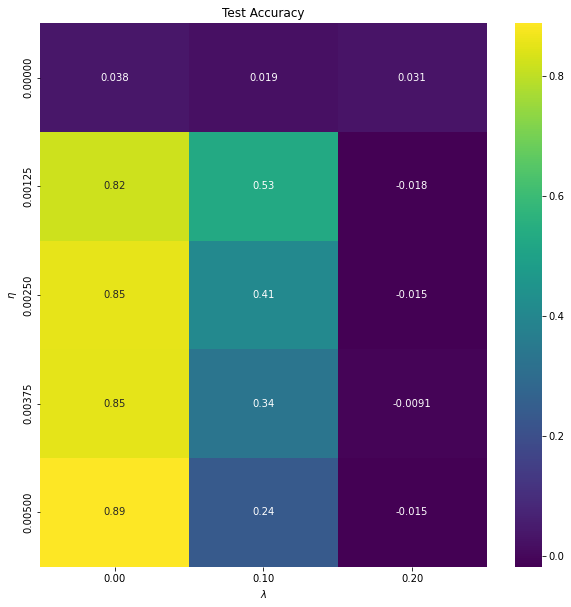

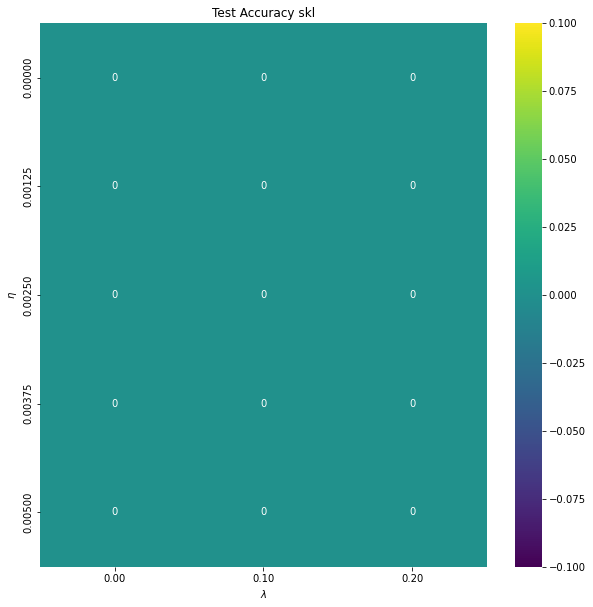

In [32]:
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Test Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
ax.set_xticklabels(["{0:0.2f}".format(i) for i in regularization] )
ax.set_yticklabels(["{0:0.5f}".format(i) for i in learning_rate] )
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy_skl, annot=True, ax=ax, cmap="viridis")
ax.set_title("Test Accuracy skl")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
ax.set_xticklabels(["{0:0.2f}".format(i) for i in regularization] )
ax.set_yticklabels(["{0:0.5f}".format(i) for i in learning_rate] )
plt.show()

## Different activation functions

- Test ut sigmoid, RELU og Leaky RELU.
- Mulig: Sjekk ut om måten eg initialiserer vekter og bias på på har noko å sei. 

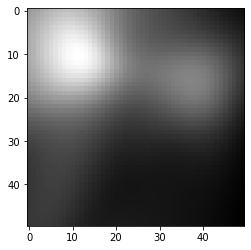

In [221]:
# Recreate franke
import matplotlib.pyplot as plt
import numpy as np


x = np.linspace(0, 1, 50)
y = np.linspace(0, 1, 50)
x, y = np.meshgrid(x, y)
noise = np.random.randn(x.shape[0], y.shape[1])
z = Fr(x, y) + noise*0.05

x = x - np.mean(x)
y = y - np.mean(y)
z = z - np.mean(z)
xy = np.hstack([x.reshape(-1, 1), y.reshape(-1, 1)])

dnn = NeuralNetwork(xy, z.reshape(-1, 1), 1, output_func, eta=learning_rate[-2], 
                                lmbd=regularization[0], epochs=n_epochs, batch_size=batch_size, 
                                hidden_layer_sizes=hidden_layer_sizes)

dnn.train()
z_pred = dnn.predict(xy).reshape(x.shape)
plt.imshow(z_pred, cmap='gray')

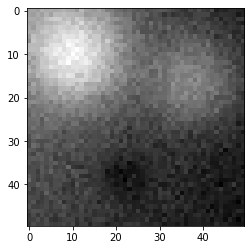

In [220]:
plt.imshow(z, cmap='gray')